# INPUT SECTION

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate the rainfall-evapoation time-series
values = [
0.   ,  1.   ,  0.6  ,  0.8  ,  0.5  ,  0.1  ,  0.3  ,  0.6  ,
        0.7  ,  0.4  , -0.1  , -0.05 , -0.1  , -0.15 , -0.05 , -0.14 ,
       -0.05 ,  0.   , -0.05 , -0.07 , -0.05 , -0.04 , -0.01 , -0.03 ,
       -0.005, -0.03 , -0.04 , -0.02 , -0.01 , -0.005,  0.   ,  0.   ,
        0.   ,  0.   ,  0.8  ,  1.5  ,  0.5  ,  0.7  , -0.18 , -0.16 ,
       -0.05 , -0.05 , -0.1  , -0.04 , -0.02 , -0.005, -0.01 , -0.005,
       -0.005, -0.05 , -0.1  ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.8  ,  1.4  ,  1.2 
]

rain_evap = np.array(values)
rain_evap #values are already in cm/day

# INPUT DATA
def setpars():
    pars={}
    pars['thetaR']=0.1060
    pars['thetaS']=0.4686
    pars['alpha']=0.0104
    pars['m']=0.28336
    pars['n']=1.3954
    pars['Ks']=13.1
    pars['Ss']=1e-6
    return pars

pars=setpars()

qT=rain_evap*-1
t=np.arange(len(qT))
dt=1
nt=len(t)

# Spatial grid:
dz=1
zN=180
z=np.arange(dz/2,zN,dz)
n=len(z)

# Initialize array:
psi=np.zeros((nt,n))

# ICs:
psi[0,:]=-10000

# MODEL SET UP

In [2]:
# DEPENDENT VARIABLES CALCULATION
def Cfun(psi,pars):
    x3=1+(pars['alpha']*np.abs(psi))**pars['n']
    x2=x3**(pars['m']+1)
    x1=pars['alpha']*pars['n']*pars['m']*((pars['alpha']*np.abs(psi))**(pars['n']-1))/x2
    C = np.where(psi >= 0, pars['Ss'], (pars['thetaS']-pars['thetaR'])*x1)
    return C

def Kfun(psi,pars):
    x6=1+(pars['alpha']*np.abs(psi))**pars['n']
    x5=x6**(pars['m']*0.5)
    x4=((pars['alpha']*np.abs(psi))**(pars['n']-1))*(x6**(-pars['m']))
    x3=1-x4
    x2=x3**2.
    x1=x2/x5
    K = np.where(psi >= 0, pars['Ks'], pars['Ks']*x1)
    return K

def thetafun(psi,pars):
    x3=1+(pars['alpha']*np.abs(psi))**pars['n']
    x2=x3**pars['m']
    x1=(pars['thetaS']-pars['thetaR'])/x2
    theta = np.where(psi >= 0, pars['thetaS'], pars['thetaR']+x1)
    return theta

# Initialize theta array based on initial psi:
theta = np.zeros((nt, n))
theta[0, :] = thetafun(psi[0, :], pars)  # Calculate initial theta

def Rfun_mixed(psiiter,psiin,qT,KB,C,Kmid,dt,dz,n,theta,thetan):
    # Calculate change in theta
    delta_theta = thetafun(psiiter, pars) - thetan
    
    # Compute the residual using the mixed form:
    zero=np.array([0])
    psigrid=np.hstack((zero,psiiter,zero))

    x1=-delta_theta/dt
    x2=(Kmid[1:]-Kmid[:-1])/dz
    x3=Kmid[1:]*(psigrid[2:]-psigrid[1:-1])/dz**2
    x4=-Kmid[:-1]*(psigrid[1:-1]-psigrid[:-2])/dz**2

    # Lower boundary:
    x2[0]=Kmid[1]/dz
    x4[0]=-KB/dz

    # Upper boundary:
    x2[-1]=-Kmid[-2]/dz
    x3[-1]=-qT/dz

    R=x1+x2+x3+x4

    return R

def Jacobian_mixed(psiiter, psiin, qT, KB, C, Kmid, dt, dz, n, R, theta, thetan):
    n_nodes = len(psiiter)
    J = np.zeros((n_nodes, n_nodes))

    for i in range(n_nodes):
        d_psi = 1e-6
        psiiter_perturbed = psiiter.copy()
        psiiter_perturbed[i] += d_psi
        theta_perturbed = thetafun(psiiter_perturbed, pars)
        delta_theta_perturbed = theta_perturbed - thetan
        
        # Compute perturbed residual with updated C and Kmid
        R_perturbed = Rfun_mixed(psiiter_perturbed, psiin, qT, KB, C, Kmid, dt, dz, n, theta_perturbed, thetan)
        
        # Compute column i of the Jacobian matrix
        J[:, i] = (R_perturbed - R) / d_psi

    return J

def iterfun_mixed(psiin, thetain, pars, qT, dt, dz, n):
    # psiin = psi^n
    # psiiter = psi^n+1,m
    # psiout = psi^n+1,m+1

    tolerance=1e-10
    maxcount=10000
    zero=np.array([0])
    
    # Initialize arrays
    psiiter=np.zeros(len(psiin))
    psiout=np.zeros(len(psiin))

    # Initial guess: psi_n+1^1 = psi_n
    psiiter[:]=psiin[:]

    # Get the initial theta based on the initial psi
    thetan = thetain[:]
    theta = thetafun(psiiter, pars)
    
    count=0
    while count <= maxcount:
        # Get C,K:
        C=Cfun(psiiter,pars)
        K=Kfun(np.hstack((zero, psiiter, zero)),pars)
        Kmid=(K[1:]+K[:-1])/2
        # Get R using the mixed form of RE
        R = Rfun_mixed(psiiter, psiin, qT, K[1], C, Kmid, dt, dz, n, theta, thetan)
        # Get the Jacobian using the mixed form of RE
        J = Jacobian_mixed(psiiter, psiin, qT, K[1], C, Kmid, dt, dz, n, R, theta, thetan)
        # Solve for delta psi using the Newton update formula
        delta_psi = np.linalg.solve(J, -R)

        # Update psi estimates
        psiout[:] = psiiter[:] + delta_psi[:]

        # Update theta based on the new psi estimates
        theta = thetafun(psiout, pars)

        # Check for convergence using the norm of delta psi
        norm_delta_psi = np.linalg.norm(delta_psi)
        if norm_delta_psi < tolerance:
            break

        # Prepare for next iteration
        psiiter[:] = psiout[:]
        count += 1

    # Check if the iteration count was exceeded
    if count == maxcount:
        raise Exception("Maximum number of iterations exceeded")

    return psiout, theta

def massbal(psi,qT,pars,n,dt,dz):

    # Initial storage:
    theta=thetafun(psi.reshape(-1),pars)
    theta=np.reshape(theta,psi.shape)
    S=np.sum(theta*dz,1)
    S0=S[0]
    SN=S[-1]

    # Inflow:
    Kin=Kfun(psi[:,0],pars)
    QIN=-Kin
    QIN[0]=0.
    QINsum=np.sum(QIN)*dt

    # Outflow:
    QOUT=qT
    QOUT[0]=0.
    QOUTsum=np.sum(QOUT)*dt

    # Balance:
    dS=SN-S0
    dQ=QINsum-QOUTsum
    err=dS/dQ

    return QIN,QOUT,S,err

def ModelRun_mixed(dt, dz, n, nt, psi, theta, qT, pars):
    # Solve:
    for j in range(1, nt):
        # Update theta for the current time step
        thetain = theta[j-1, :]

        # Run the iteration function for the mixed form
        psi[j, :], theta[j, :] = iterfun_mixed(psi[j-1, :], thetain, pars, qT[j], dt, dz, n)

    # Calculate mass balance with the mixed form
    QIN, QOUT, S, err = massbal(psi, qT, pars, n, dt, dz)

    return psi, QIN, QOUT, S, err

# SIMULATION RUN

In [3]:
psi,QIN,QOUT,S,err=ModelRun_mixed(dt,dz,n,nt,psi,theta,qT,pars)

LinAlgError: Singular matrix

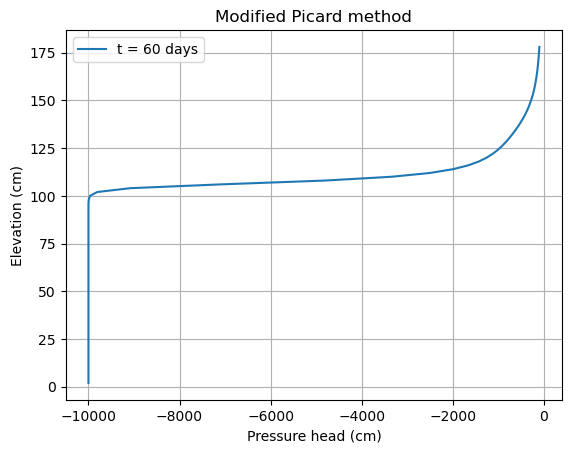

In [4]:
psi_plot = plt.plot(psi[59], z, label='t = 60 days') # Plot z vs psi for each dti
plt.xlabel('Pressure head (cm)')
plt.ylabel('Elevation (cm)')
plt.title('Modified Picard method')
plt.legend()  # Show legend with dti values
plt.grid(True)
plt.show()

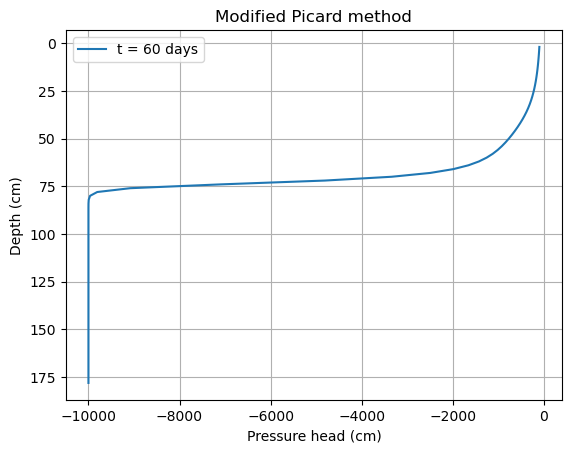

In [5]:
z_depth = np.flip(z)
psi_plot = plt.plot(psi[59], z_depth, label='t = 60 days') # Plot z vs psi for each dti
plt.xlabel('Pressure head (cm)')
plt.ylabel('Depth (cm)')
plt.gca().invert_yaxis()
plt.title('Modified Picard method')
plt.legend()  # Show legend with dti values
plt.grid(True)
plt.show()

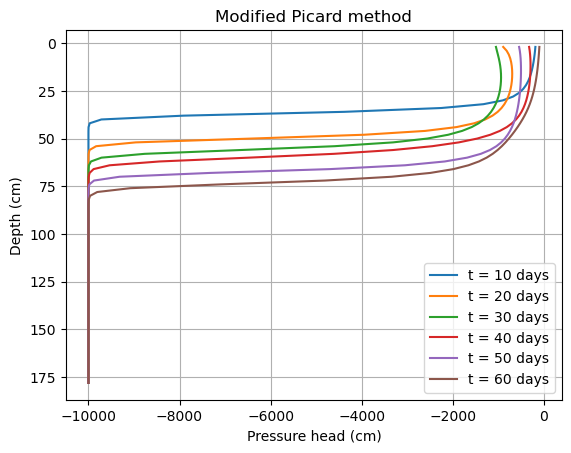

In [6]:
# Specify the time steps you want to plot
time_steps = [9, 19, 29, 39, 49, 59]  # Adjusted for zero-indexing

# Loop through the specified time steps
for t in time_steps:
    plt.plot(psi[t], z_depth, label=f't = {t+1} days')  # t+1 because of zero-indexing but your days start from 1

plt.xlabel('Pressure head (cm)')
plt.ylabel('Depth (cm)')
plt.gca().invert_yaxis()
plt.title('Modified Picard method')
plt.legend()  # Show legend with dti values
plt.grid(True)
plt.show()

In [7]:
Kmid

NameError: name 'Kmid' is not defined